## 1. Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')
# данная магическая команда нужна для того, чтобы графики отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

In [2]:
sns.set(style='whitegrid')

## 2. Записываем в переменные путь для файлов

In [3]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'

## 3. Перевод csv в датафрэйм

In [4]:
df_train = pd.read_csv(TRAIN_PATH, sep=',', index_col='Id')
df_test = pd.read_csv(TEST_PATH, sep=',', index_col='Id')

In [5]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [7]:
df_train.shape, df_test.shape

((10000, 19), (5000, 18))

## 4. Проверка датафрейма на дубликаты

In [8]:
df_train.duplicated().unique(), df_test.duplicated().unique()

(array([False]), array([False]))

## 5. Анализ датафреймов test и train

In [9]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Столбцы Ecology_2, Ecology_3, Shops_2 имею тип object проверим, какие значения они имеют:

In [10]:
object_type = df_train.select_dtypes(include=['object'])
for i in object_type:
    print(f"Столбец {i} в train содержит {df_train[i].unique()}")
    print(f"Столбец {i} в test содержит {df_test[i].unique()}")

Столбец Ecology_2 в train содержит ['B' 'A']
Столбец Ecology_2 в test содержит ['B' 'A']
Столбец Ecology_3 в train содержит ['B' 'A']
Столбец Ecology_3 в test содержит ['B' 'A']
Столбец Shops_2 в train содержит ['B' 'A']
Столбец Shops_2 в test содержит ['B' 'A']


Заменим A, B на 0 и 1:

In [11]:
for i in object_type:
    df_train[i] = df_train[i].map({'A': 0, 'B': 1})
    df_test[i] = df_test[i].map({'A': 0, 'B': 1})

Поиск аномалий

In [12]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [13]:
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.917600
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,0.275001
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,1.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


1. Видно, что по max значениям есть аномалии:
* Square - 641.065193, 
* LifeSquare - 7480.592129, 
* KitchenSquare - 2014.000000,
* HouseYear - 2.005201e+07	
* Rooms также вызывает сомнения - 19

2. Проверка через .nlargest показала:
* LifeSquare - аномалия, после 7480.592129 идет сразу 638.163193. При этом общая площадь - 81.7
* KitchenSquare - 2 аномалии 2014.0	и 1970.0. Обащая площадь в данных домах 47.1 и 32.2, соответственно.
* HouseYear - 2 аномалии 20052011 и 4968
* Rooms - похоже на 3 аномалии 19 комнат при 42 кв.м., 10 комнат при 59 кв.м. и 10 комнат при 60,9 кв.м.

## 6. Заменим HouseYear

In [14]:
df_train['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [15]:
df_train.loc[df_train['HouseYear'] > 2021]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096


Дом с годом 4968 находится в 147 квартале. Посмотрим, какие дома там встречаются

In [16]:
df_train.loc[df_train['DistrictId'] == 147]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2552,147,2.0,44.778548,27.776470,5.0,6,9.0,1966,0.319809,1,1,25,4756,16,2857.0,5,8,1,244785.344750
7269,147,2.0,47.796704,28.619983,5.0,6,5.0,1964,0.319809,1,1,25,4756,16,2857.0,5,8,1,198011.162378
6690,147,2.0,54.101741,34.958241,9.0,4,12.0,1974,0.319809,1,1,25,4756,16,2857.0,5,8,1,269840.533419
5011,147,3.0,60.421346,41.264562,6.0,2,9.0,1959,0.319809,1,1,25,4756,16,2857.0,5,8,1,286171.778415
1414,147,1.0,37.836561,21.208420,9.0,11,14.0,1973,0.319809,1,1,25,4756,16,2857.0,5,8,1,198633.629010
13613,147,2.0,41.525814,27.643522,6.0,5,14.0,1975,0.319809,1,1,25,4756,16,2857.0,5,8,1,208333.693856
2102,147,1.0,36.430095,18.738042,9.0,2,12.0,1970,0.319809,1,1,25,4756,16,2857.0,5,8,1,170108.140818
16580,147,3.0,72.357021,55.627106,5.0,4,9.0,1970,0.319809,1,1,25,4756,16,2857.0,5,8,1,349370.324979
8737,147,2.0,66.496862,35.145412,8.0,4,10.0,1961,0.319809,1,1,25,4756,16,2857.0,5,8,1,352506.858211


Отберем дома с характеристиками, аналогичные искомой квартире. Выберем этажность дома и кол-во комнат.

In [17]:
df_train.loc[(df_train['DistrictId'] == 147) & (df_train['HouseFloor'] == 9) & (df_train['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2552,147,2.0,44.778548,27.776470,5.0,6,9.0,1966,0.319809,1,1,25,4756,16,2857.0,5,8,1,244785.344750
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096


Как видно, все характеристики совпадают, площадь и цена отличаются оч. мало. Делаем вывод, что вместо 4968 необходимо 1966. Заменим этим значением.

In [18]:
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1966

df_train.loc[(df_train['DistrictId'] == 147) & (df_train['HouseFloor'] == 9) & (df_train['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2552,147,2.0,44.778548,27.776470,5.0,6,9.0,1966,0.319809,1,1,25,4756,16,2857.0,5,8,1,244785.344750
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,1966,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096


По аналогии  найдем год у квартиры с годом 20052011. У нее 109 квартал.

In [19]:
df_train.loc[df_train['DistrictId'] == 109]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13759,109,1.0,40.117364,21.391898,10.0,5,22.0,1982,0.000000,1,1,25,5027,4,46.0,1,1,1,239038.590023
5756,109,2.0,53.078404,30.055048,9.0,3,17.0,2002,0.136330,1,1,30,6141,10,262.0,3,6,1,377934.005629
7765,109,1.0,31.123567,24.856298,5.0,8,9.0,1965,0.136330,1,1,30,6141,10,262.0,3,6,1,184873.032487
11521,109,1.0,43.975430,22.525571,8.0,16,17.0,1999,0.136330,1,1,30,6141,10,262.0,3,6,1,263580.916064
424,109,2.0,46.084526,28.946348,6.0,4,10.0,1968,0.136330,1,1,30,6141,10,262.0,3,6,1,247187.598965
869,109,1.0,39.784653,21.849179,8.0,2,17.0,1995,0.136330,1,1,30,6141,10,262.0,3,6,1,193067.159413
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
3185,109,2.0,54.002829,33.414232,8.0,25,25.0,2011,0.136330,1,1,30,6141,10,262.0,3,6,1,387360.806840
6352,109,4.0,100.904263,65.110698,10.0,8,22.0,1985,0.000000,1,1,25,5027,4,46.0,1,1,1,513832.467690


In [20]:
df_train.loc[(df_train['DistrictId'] == 109) & (df_train['KitchenSquare'] == 9) & (df_train['Healthcare_1'] == 262)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5756,109,2.0,53.078404,30.055048,9.0,3,17.0,2002,0.13633,1,1,30,6141,10,262.0,3,6,1,377934.005629
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.13633,1,1,30,6141,10,262.0,3,6,1,254084.534396
15956,109,2.0,62.388710,31.700385,9.0,14,24.0,2009,0.13633,1,1,30,6141,10,262.0,3,6,1,408520.958318
13508,109,1.0,45.144292,19.846351,9.0,8,24.0,2012,0.13633,1,1,30,6141,10,262.0,3,6,1,311895.441450


Путем различным проверок можно предположить, что дом 2005 года. Заменим это значение.

In [21]:
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2005

## 7. Приведем в соответствие этаж квартиры и этажность дома.

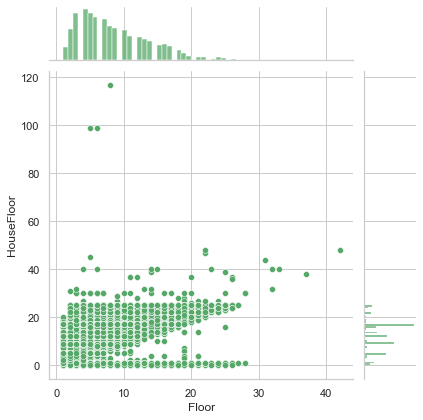

In [22]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=6, color='g');

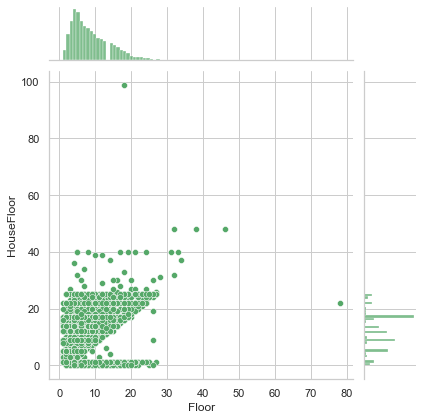

In [23]:
sns.jointplot(df_test['Floor'], df_test['HouseFloor'], kind='scatter', height=6, color='g');

In [24]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
48.0        2
99.0        2
39.0        2
117.0       1
29.0        1
31.0        1
38.0        1
44.0        1
36.0        1
26.0        1
45.0        1
47.0        1
Name: HouseFloor, dtype: int64

In [25]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1,221244.156664
10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,140647.565937
2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,NaN,0,0,1,117000.381287
11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,127200.026511
6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,1,1,34,7065,1,750.0,2,5,1,226434.880156
16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,95529.569405
4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,1,1,53,14892,4,NaN,1,4,1,441108.911237


Имеем 1825 квартир, у которых этаж больше этажности дома.

In [26]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
48.0        2
99.0        2
39.0        2
117.0       1
29.0        1
31.0        1
38.0        1
44.0        1
36.0        1
26.0        1
45.0        1
47.0        1
Name: HouseFloor, dtype: int64

Меняю кол-во этажей дома по следующему алгоритму: 
* Делаем выборку этаж квартиры > этажности дома
* Берем квартиры из одного района и одного года постройки
* Считаем макс этаж квартиры и заполняем этим номером этажность дома

In [27]:
df_floor_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
df_floor_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']]

DistrictId_train = df_floor_train["DistrictId"].unique()
HouseYear_train = df_floor_train["HouseYear"].unique()
DistrictId_test = df_floor_test["DistrictId"].unique()
HouseYear_test = df_floor_test["HouseYear"].unique()

for w in DistrictId_train:
    for a in HouseYear_train:
        df_train.loc[(df_train['Floor'] > df_train['HouseFloor']) & (df_train["DistrictId"] == w) & (df_train["HouseYear"] == a), 'HouseFloor'] = \
        df_train.loc[(df_train["DistrictId"] == w) & (df_train["HouseYear"] == a)]['HouseFloor'].max()

for w in DistrictId_test:
    for a in HouseYear_test:
        df_test.loc[(df_test['Floor'] > df_test['HouseFloor']) & (df_test["DistrictId"] == w) & (df_test["HouseYear"] == a), 'HouseFloor'] = \
        df_test.loc[(df_test["DistrictId"] == w) & (df_test["HouseYear"] == a)]['HouseFloor'].max()

In [28]:
df_test.loc[df_test['HouseFloor'] > 60]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5214,27,1.0,37.555197,NaN,1.0,5,99.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1
8968,27,2.0,69.849239,NaN,0.0,3,99.0,1977,0.011654,1,1,4,915,0,NaN,0,0,1
10614,27,1.0,44.254995,NaN,1.0,3,99.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1
12743,27,1.0,40.407390,NaN,0.0,9,99.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1
14834,27,3.0,56.310351,NaN,0.0,19,99.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,27,1.0,51.492952,NaN,0.0,5,99.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0
3443,27,1.0,47.952984,17.935503,1.0,9,99.0,1977,0.017647,1,1,2,469,0,NaN,0,0,1
4466,27,3.0,83.861005,45.515491,12.0,2,99.0,1977,0.017647,1,1,2,469,0,NaN,0,0,1


In [29]:
# по аналогии заменим этажи выше 90
df_floor_train = df_train.loc[df_train['HouseFloor'] > 90]
df_floor_test = df_test.loc[df_test['HouseFloor'] > 90]

DistrictId_train = df_floor_train["DistrictId"].unique()
HouseYear_train = df_floor_train["HouseYear"].unique()
DistrictId_test = df_floor_test["DistrictId"].unique()
HouseYear_test = df_floor_test["HouseYear"].unique()

for w in DistrictId_train:
    for a in HouseYear_train:
        df_train.loc[(df_train['HouseFloor'] > 90) & (df_train["DistrictId"] == w) & (df_train["HouseYear"] == a), 'HouseFloor'] = \
        df_train.loc[(df_train["DistrictId"] == w) & (df_train["HouseYear"] == a)]['Floor'].max()

for w in DistrictId_test:
    for a in HouseYear_test:
        df_test.loc[(df_test['HouseFloor'] > 90) & (df_test["DistrictId"] == w) & (df_test["HouseYear"] == a), 'HouseFloor'] = \
        df_test.loc[(df_test["DistrictId"] == w) & (df_test["HouseYear"] == a)]['Floor'].max()

In [30]:
# оставшиеся значения по аналогии приравняем к виду Floor = HouseFloor
df_floor_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
df_floor_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']]

DistrictId_train = df_floor_train["DistrictId"].unique()
HouseYear_train = df_floor_train["HouseYear"].unique()
DistrictId_test = df_floor_test["DistrictId"].unique()
HouseYear_test = df_floor_test["HouseYear"].unique()

for w in DistrictId_train:
    for a in HouseYear_train:
        df_train.loc[(df_train['Floor'] > df_train['HouseFloor']) & (df_train["DistrictId"] == w) & (df_train["HouseYear"] == a), 'HouseFloor'] = \
        df_train.loc[(df_train["DistrictId"] == w) & (df_train["HouseYear"] == a)]['Floor'].max()

for w in DistrictId_test:
    for a in HouseYear_test:
        df_test.loc[(df_test['Floor'] > df_test['HouseFloor']) & (df_test["DistrictId"] == w) & (df_test["HouseYear"] == a), 'HouseFloor'] = \
        df_test.loc[(df_test["DistrictId"] == w) & (df_test["HouseYear"] == a)]['Floor'].max()

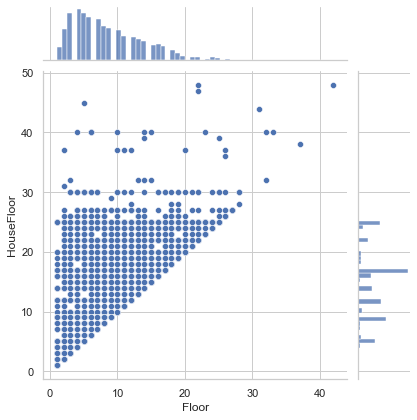

In [31]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=6, color='b');

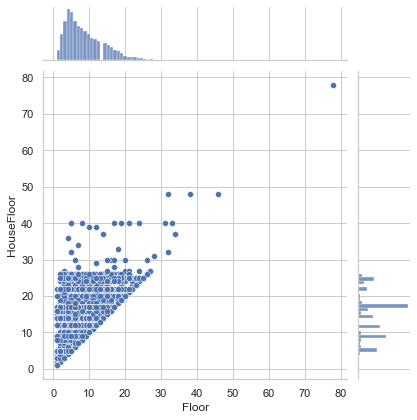

In [32]:
sns.jointplot(df_test['Floor'], df_test['HouseFloor'], kind='scatter', height=6, color='b');

Есть квартира/квартиры на этаже > 70

In [33]:
df_test.loc[df_test['HouseFloor'] > 70]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
15759,17,2.0,57.60187,37.744743,10.0,78,78.0,1989,0.0,1,1,25,5027,4,46.0,1,1,1


In [34]:
df_test.loc[(df_test['HouseYear'] == 1989) & (df_test['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
8664,1,2.0,55.955066,33.825738,9.0,4,17.0,1989,0.025609,1,1,33,5261,0,240.0,3,1,1
217,80,2.0,59.439563,33.991547,10.0,11,17.0,1989,0.000000,1,1,39,8647,0,810.0,0,5,1
15056,90,2.0,55.500029,33.230081,8.0,5,17.0,1989,0.246032,1,0,22,3151,4,2715.0,3,3,1
6135,146,2.0,56.466468,32.423098,8.0,15,17.0,1989,0.236108,1,1,16,3893,27,NaN,3,10,1
4600,145,2.0,61.933242,36.958781,10.0,16,17.0,1989,0.000000,1,1,30,5562,0,NaN,0,5,0
14683,10,2.0,52.706774,34.387091,8.0,6,17.0,1989,0.089040,1,1,33,7976,5,NaN,0,11,1
4963,67,2.0,55.101369,33.968217,8.0,18,18.0,1989,0.100456,1,1,43,7227,0,NaN,1,6,0
2397,55,2.0,62.954899,36.116386,10.0,15,17.0,1989,0.041365,1,1,31,5569,0,NaN,1,4,1
10552,10,2.0,53.283788,32.472275,8.0,18,18.0,1989,0.089040,1,1,33,7976,5,NaN,0,11,1


По данным видно, что данного года дом, с 2 комнатами и похожими другими характеристиками находится на 17 этаже. Заменим этим значением

In [35]:
df_test.loc[df_test['HouseFloor'] == 78, 'HouseFloor'] = 17
df_test.loc[df_test['Floor'] == 78, 'Floor'] = 17

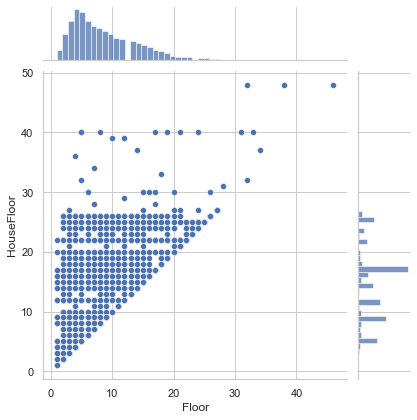

In [36]:
sns.jointplot(df_test['Floor'], df_test['HouseFloor'], kind='scatter', height=6, color='b');

## 8. Проверка площади квартиры

### Обработаем выбросы

LifeSquare - аномалия, после 7480.592129 идет сразу 638.163193. При этом общая площадь - 81.7
KitchenSquare - 2 аномалии 2014.0 и 1970.0. Обащая площадь в данных домах 47.1 и 32.2, соответственно.

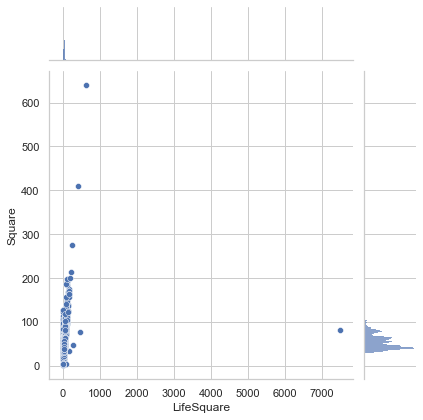

In [37]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6, color='b');

Заменим значение в квартире с площадью кухни > 7000

In [38]:
df_train.loc[df_train['LifeSquare'] > 7000]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,1,1,2,469,0,NaN,0,0,1,217357.492366


In [39]:
df_train.loc[(df_train['DistrictId'] == 27) & (df_train['HouseYear'] == 2016) & (df_train['Rooms'] == 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4732,27,3.0,85.345233,82.928870,1.0,13,20.0,2016,0.072158,1,1,2,629,1,NaN,0,0,0,265311.516986
16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,1,1,2,469,0,NaN,0,0,1,217357.492366
4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,NaN,0,1,1,161379.067034
1772,27,3.0,83.614701,49.651464,1.0,12,25.0,2016,0.072158,1,1,2,629,1,NaN,0,0,0,260724.334651
5266,27,3.0,79.339322,NaN,12.0,6,19.0,2016,0.211401,1,1,9,1892,0,NaN,0,1,1,168039.151275
4703,27,3.0,80.416784,42.097827,1.0,7,14.0,2016,0.017647,1,1,2,469,0,NaN,0,0,1,228740.425442
6392,27,3.0,49.029747,NaN,0.0,17,25.0,2016,0.072158,1,1,2,629,1,NaN,0,0,0,138397.357122
11396,27,3.0,85.814247,86.234909,10.0,3,17.0,2016,0.072158,1,1,2,629,1,NaN,0,0,0,237651.014349
7830,27,3.0,80.510399,45.299249,1.0,16,25.0,2016,0.017647,1,1,2,469,0,NaN,0,0,1,213688.711749


In [40]:
df_train.loc[df_train['LifeSquare'] > 7000, 'LifeSquare'] = df_train['LifeSquare'] / 100

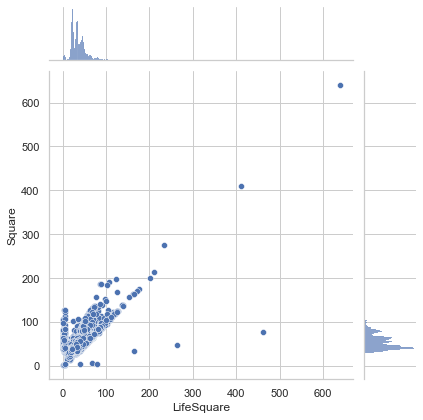

In [41]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6, color='b');

In [42]:
df_train.loc[df_train['LifeSquare'] > 200]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14990,23,2.0,48.449873,263.542020,5.0,6,6.0,1972,0.075779,1,1,6,1437,3,NaN,0,2,1,141780.231857
7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,NaN,0,1,1,302211.260887
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,455264.882666
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,90470.430830
11602,30,2.0,641.065193,638.163193,10.0,20,20.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,133529.681562
15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,1,1,52,11217,1,2300.0,1,7,1,394253.299978
16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,NaN,1,4,1,528560.506016


Посмотрим какие еще есть квартиры в доме, где квартира на 600 квадратов.

In [43]:
df_train.loc[(df_train['HouseYear'] == 2019) & (df_train['DistrictId'] == 30)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11602,30,2.0,641.065193,638.163193,10.0,20,20.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,133529.681562


In [44]:
df_train.loc[(df_train['HouseYear'] == 2019) & (df_train['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2453,52,2.0,68.111212,64.181422,0.0,4,17.0,2019,0.371149,1,1,34,7065,1,750.0,2,5,1,176037.781296
5273,23,2.0,53.199650,32.459052,9.0,3,3.0,2019,0.005767,1,1,1,388,0,NaN,0,0,1,94061.943579
12934,62,2.0,78.328502,79.316511,0.0,9,9.0,2019,0.072158,1,1,2,629,1,NaN,0,0,0,202224.173139
728,33,2.0,46.239419,48.579636,10.0,3,10.0,2019,0.236108,1,1,16,3893,27,NaN,3,10,1,197111.117941
1154,34,2.0,61.357367,61.673014,10.0,18,25.0,2019,0.069753,1,1,53,13670,4,NaN,1,11,1,260051.757992
7866,1,2.0,66.868482,NaN,9.0,5,20.0,2019,0.007122,1,1,1,264,0,NaN,0,1,1,200728.496279
5835,23,2.0,60.769644,59.878101,10.0,4,17.0,2019,0.075779,1,1,6,1437,3,NaN,0,2,1,175066.746701
9838,23,2.0,54.906941,58.338478,10.0,3,3.0,2019,0.005767,1,1,1,388,0,NaN,0,0,1,83530.831950
16364,1,2.0,65.822188,54.148652,9.0,3,9.0,2019,0.007122,1,1,1,264,0,NaN,0,1,1,199316.883485


Делаем вывод, что площадь квартиры и жилой площади увеличено на 10. Поменяем эти значания.

In [45]:
df_train.loc[df_train['LifeSquare'] > 600, 'LifeSquare'] = df_train['LifeSquare'] / 10
df_train.loc[df_train['Square'] > 600, 'Square'] = df_train['Square'] / 10

По аналогии посмотрим квартары с площадью более 400 кв.

In [46]:
df_train.loc[df_train['LifeSquare'] > 400]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,90470.430830
15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,1,1,52,11217,1,2300.0,1,7,1,394253.299978


Также делим на 10

In [47]:
df_train.loc[df_train['LifeSquare'] > 400, 'LifeSquare'] = df_train['LifeSquare'] / 10
df_train.loc[df_train['Square'] > 400, 'Square'] = df_train['Square'] / 10

In [48]:
df_train.loc[(df_train['HouseYear'] == 1998) & (df_train['HouseFloor'] == 16.0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1169,9,1.0,38.533589,18.689752,10.0,8,16.0,1998,0.069753,1,1,53,13670,4,NaN,1,11,1,195593.217821
1656,8,1.0,41.241272,19.273764,9.0,2,16.0,1998,0.458174,1,0,26,4439,1,1130.0,1,5,1,158608.106249
9141,128,1.0,35.140585,17.946795,10.0,12,16.0,1998,0.000000,1,1,27,4798,0,30.0,2,8,1,194086.706897
2879,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,1,1,21,4346,2,165.0,1,2,1,496026.671162
15886,85,3.0,78.059331,46.146361,10.0,12,16.0,1998,0.037178,1,1,52,11217,1,2300.0,1,7,1,394253.299978


По аналогии посмотрим квартары с площадью более 200 кв. Делим на 10.

In [49]:
df_train.loc[df_train['LifeSquare'] > 200, 'LifeSquare'] = df_train['LifeSquare'] / 10

In [50]:
df_train.loc[df_train['Square'] > 200, 'Square'] = df_train['Square'] / 10

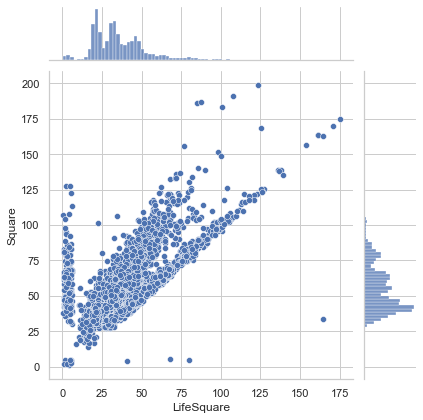

In [51]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6, color='b');

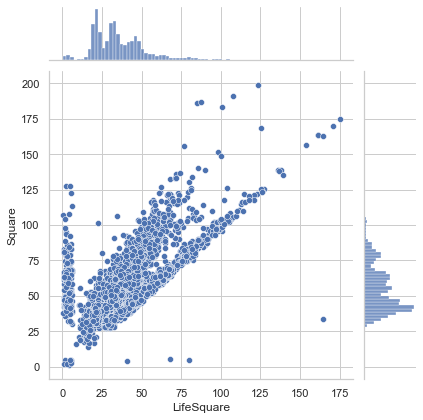

In [52]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6, color='b');

Посмотрим площадь кухни

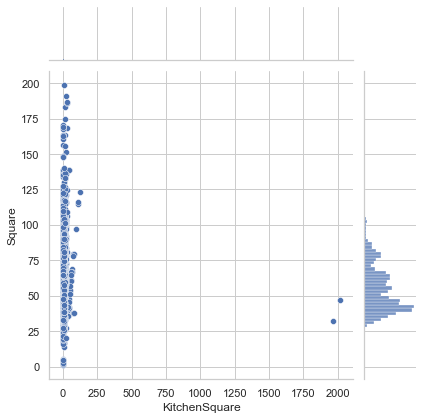

In [53]:
sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6, color='b');

In [54]:
df_train.loc[df_train['KitchenSquare'] > 250]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,20.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
14679,81,1.0,32.276663,19.278394,1970.0,6,9.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275


Видим, что вместо размера кухни записан год. При этом по одному дому он не совпадает с годом дома. Заменим год дома.

In [55]:
df_train.loc[df_train['KitchenSquare'] == 1970, 'HouseYear'] = 1970

Теперь отработаем площади.

In [56]:
df_train.loc[(df_train['HouseYear'] == 2014) & (df_train['DistrictId'] == 62)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,20.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
16753,62,3.0,89.573600,NaN,1.0,10,20.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,233681.472368
14534,62,2.0,73.277010,40.192382,12.0,8,9.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,171255.856287
8140,62,1.0,56.667328,NaN,1.0,3,18.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,133632.342875
16092,62,3.0,96.009479,NaN,0.0,4,20.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,209637.158007
3703,62,2.0,73.730455,NaN,1.0,9,20.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,185861.944750
11846,62,2.0,67.558343,36.917665,16.0,16,17.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,109129.982392


In [57]:
df_train.loc[df_train['KitchenSquare'] == 2014, 'KitchenSquare'] = 1

In [58]:
df_train.loc[(df_train['HouseYear'] == 1970) & (df_train['Rooms'] == 1)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1982,28,1.0,38.007936,23.281714,9.0,1,12.0,1970,0.118537,1,1,30,6207,1,1183.0,1,0,1,147636.760356
3893,39,1.0,35.802254,20.598622,9.0,9,12.0,1970,0.428826,1,1,25,5011,8,730.0,0,2,1,181888.651555
5841,94,1.0,36.044243,18.497213,6.0,2,9.0,1970,0.282798,1,1,33,8667,2,NaN,0,6,1,166454.398122
14874,2,1.0,34.884511,21.298503,6.0,5,9.0,1970,0.309479,1,1,35,7715,4,990.0,0,6,1,170996.036686
697,73,1.0,39.442055,22.186361,9.0,6,12.0,1970,0.042032,1,1,37,6856,84,1940.0,2,5,1,246405.867242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,21,1.0,38.859265,22.043002,9.0,10,12.0,1970,0.034331,1,1,25,5487,3,NaN,0,4,1,163401.301060
16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,1,1,47,8004,3,125.0,3,5,1,151827.177876
10152,7,1.0,33.479009,21.502835,5.0,3,5.0,1970,0.130618,1,1,39,10418,9,900.0,1,9,1,186424.180662


In [59]:
df_train.loc[df_train['KitchenSquare'] == 1970, 'KitchenSquare'] = df_train.loc[(df_train['HouseYear'] == 1970) & (df_train['Rooms'] == 1)]['KitchenSquare'].median()

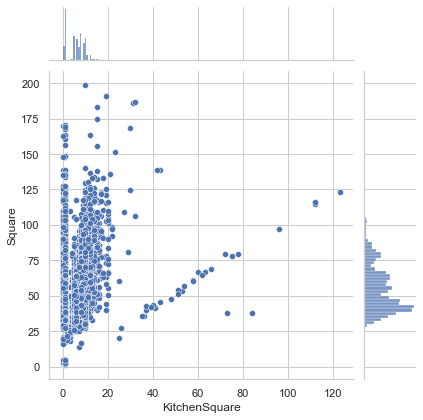

In [60]:
sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6, color='b');

In [61]:
df_train.loc[df_train['KitchenSquare'] > df_train['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,NaN,0,0,1,99079.960518
16568,27,4.0,20.033454,20.162736,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,NaN,1,4,1,528560.506016


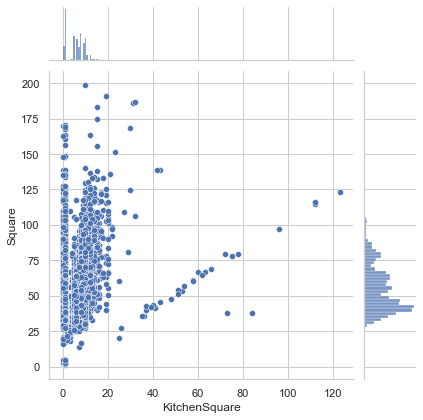

In [62]:
sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6, color='b');

По аналогии пройду по test

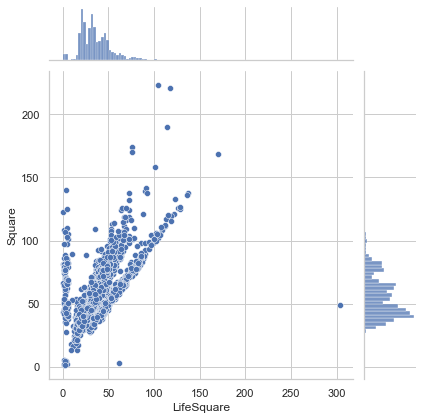

In [63]:
sns.jointplot(df_test['LifeSquare'], df_test['Square'], kind='scatter', height=6, color='b');

In [64]:
df_test.loc[df_test['LifeSquare'] > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,1,1,25,6149,0,NaN,0,0,1


In [65]:
df_test.loc[df_test['LifeSquare'] > 300, 'LifeSquare'] = df_test['LifeSquare'] / 10

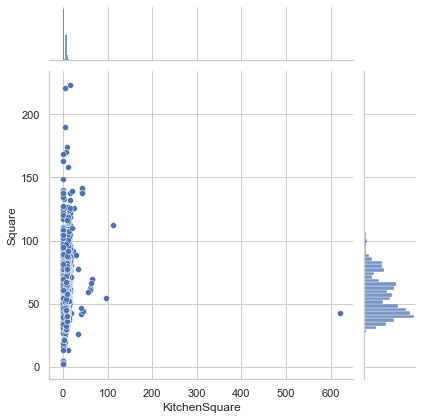

In [66]:
sns.jointplot(df_test['KitchenSquare'], df_test['Square'], kind='scatter', height=6, color='b');

In [67]:
df_test.loc[df_test['KitchenSquare'] > 500]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14594,11,2.0,42.795304,24.22377,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1


In [68]:
df_test.loc[(df_test['HouseYear'] == 1972) & (df_test['DistrictId'] == 11) & (df_test['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1
6476,11,2.0,40.846070,28.488986,6.0,10,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1


In [69]:
df_train.loc[(df_train['HouseYear'] == 1972) & (df_train['DistrictId'] == 11) & (df_train['Rooms'] == 2)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
522,11,2.0,48.372232,31.007581,6.0,4,9.0,1972,0.000170,1,1,36,5992,0,NaN,1,1,1,213374.166403
2010,11,2.0,46.229645,30.836898,5.0,7,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,223678.739216
4292,11,2.0,47.297188,32.180328,6.0,6,9.0,1972,0.000170,1,1,36,5992,0,NaN,1,1,1,206143.380399
1101,11,2.0,46.071368,30.131139,6.0,5,9.0,1972,0.000170,1,1,36,5992,0,NaN,1,1,1,184146.196411
12789,11,2.0,46.919706,30.620938,6.0,14,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,199260.275978
9582,11,2.0,46.048604,29.979645,6.0,3,9.0,1972,0.000170,1,1,36,5992,0,NaN,1,1,1,192771.857357


In [70]:
df_test.loc[df_test['KitchenSquare'] > 500, 'KitchenSquare'] = \
            df_train.loc[(df_train['HouseYear'] == 1972) & (df_train['DistrictId'] == 11) & \
            (df_train['Rooms'] == 2)]['KitchenSquare'].median()

Отработаем значения по площади меньше 10 

In [71]:
df_test.loc[df_test['LifeSquare'] < 10]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3495,27,3.0,82.652818,5.690155,1.0,4,17.0,2015,0.072158,1,1,2,629,1,NaN,0,0,0
9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1
9205,120,2.0,85.911827,4.188395,1.0,5,5.0,2016,0.341072,1,1,27,5664,48,2300.0,3,11,1
7034,45,2.0,59.927502,3.798341,1.0,23,25.0,2017,0.195781,1,1,23,5212,6,NaN,3,2,1
6553,34,5.0,122.375273,0.333490,0.0,9,22.0,1977,0.069753,1,1,53,13670,4,NaN,1,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8963,27,3.0,79.114387,3.329216,1.0,3,22.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1
5002,1,3.0,82.624843,4.379317,1.0,5,17.0,2016,0.007122,1,1,1,264,0,NaN,0,1,1
4611,27,2.0,76.709543,2.989508,1.0,13,25.0,2016,0.072158,1,1,2,629,1,NaN,0,0,0


In [72]:
# сначала меняем значения на Square
df_square_train = df_train.loc[df_train['Square'] < 10]
df_square_test = df_test.loc[df_test['Square'] < 10]

Rooms_train = df_square_train['Rooms'].unique()
HouseYear_train = df_square_train['HouseYear'].unique()
Rooms_test = df_square_test['Rooms'].unique()
HouseYear_test = df_square_test['HouseYear'].unique()

for w in HouseYear_train:
    for a in Rooms_train:
        df_train.loc[(df_train['Square'] < 10) & (df_train['HouseYear'] == w) & (df_train['Rooms'] == a), 'Square'] = \
        df_train.loc[(df_train['HouseYear'] == w) & (df_train['Rooms'] == a)]['Square'].median()

for w in HouseYear_test:
    for a in Rooms_test:
        df_test.loc[(df_test['Square'] < 10) & (df_test['HouseYear'] == w) & (df_test['Rooms'] == a), 'Square'] = \
        df_train.loc[(df_train["HouseYear"] == w) & (df_train['Rooms'] == a)]['Square'].median()

# потом меняем значения на LifeSquare
df_lsquare_train = df_train.loc[df_train['LifeSquare'] < 10]
df_lsquare_test = df_test.loc[df_test['LifeSquare'] < 10]

Rooms_train = df_lsquare_train['Rooms'].unique()
HouseYear_train = df_lsquare_train['HouseYear'].unique()
Rooms_test = df_lsquare_test['Rooms'].unique()
HouseYear_test = df_lsquare_test['HouseYear'].unique()

for w in HouseYear_train:
    for a in Rooms_train:
        df_train.loc[(df_train['LifeSquare'] < 10) & (df_train["HouseYear"] == w) & (df_train["Rooms"] == a), 'LifeSquare'] = \
        df_train.loc[(df_train["HouseYear"] == w) & (df_train["Rooms"] == a)]['LifeSquare'].median()

for w in HouseYear_test:
    for a in Rooms_test:
        df_test.loc[(df_train['LifeSquare'] < 10) & (df_test['HouseYear'] == w) & (df_test['Rooms'] == a), 'LifeSquare'] = \
        df_train.loc[(df_train['HouseYear'] == w) & (df_train['Rooms'] == a)]['LifeSquare'].median()

Отработаем LifeSquare > Square и KitchenSquare > Square

In [73]:
df_train.loc[df_train['LifeSquare'] > df_train['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
10521,38,3.0,104.211396,106.340403,0.0,20,20.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,1,1,1,264,0,NaN,0,1,1,199215.452229
8753,25,3.0,85.952306,89.803753,1.0,4,25.0,2017,0.069753,1,1,53,13670,4,NaN,1,11,1,309688.592681
9870,62,1.0,51.831473,53.491301,1.0,5,17.0,2015,0.072158,1,1,2,629,1,NaN,0,0,0,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,1,126281.142781
12918,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,1,1,1,388,0,NaN,0,0,1,88150.012510
2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,1,1,2,469,0,NaN,0,0,1,234194.837047


In [74]:
df_test.loc[df_test['LifeSquare'] > df_test['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
11160,58,1.0,48.610661,48.752502,1.0,4,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1
6624,27,1.0,42.413793,42.434887,10.0,12,17.0,2017,0.011654,1,1,4,915,0,NaN,0,0,1
11513,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1
1872,30,2.0,52.449057,52.798349,1.0,17,17.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686,1,3.0,77.229885,79.958685,1.0,18,24.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1
3711,94,1.0,41.281057,42.392594,10.0,13,13.0,2014,0.282798,1,1,33,8667,2,NaN,0,6,1
5820,94,1.0,33.680382,34.198977,1.0,10,12.0,1972,0.127376,1,1,43,8429,3,NaN,3,9,1


In [75]:
df_train.loc[df_train['KitchenSquare'] > df_train['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,NaN,0,0,1,99079.960518
16568,27,4.0,20.033454,20.162736,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,NaN,1,4,1,528560.506016


In [76]:
df_train.loc[(df_train['HouseYear'] == 2018) & (df_train['DistrictId'] == 27) & (df_train['HouseFloor'] == 17), 'KitchenSquare'] =\
10

In [77]:
df_train.loc[df_train['KitchenSquare'] == 73, 'KitchenSquare'] = 7

In [78]:
df_train.loc[df_train['KitchenSquare'] == 25, 'KitchenSquare'] = 1

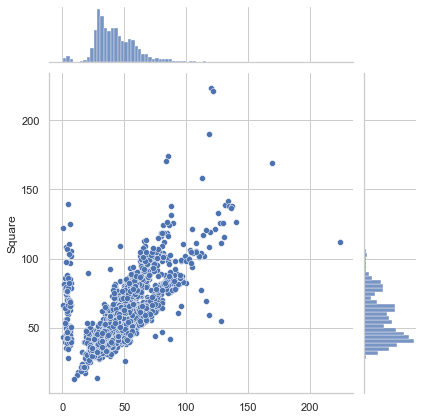

In [79]:
sns.jointplot((df_test['KitchenSquare'] + df_test['LifeSquare']), df_test['Square'], kind='scatter', height=6, color='b');

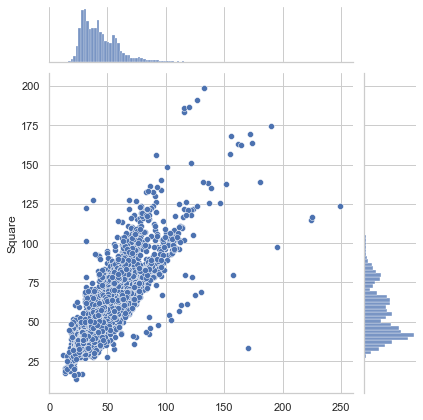

In [80]:
sns.jointplot((df_train['KitchenSquare'] + df_train['LifeSquare']), df_train['Square'], kind='scatter', height=6, color='b');

In [81]:
#Данная замена уменьшает R2, нужно подумать, как по другому поменять.

# df_train.loc[(df_train['Square'] < df_train['LifeSquare'] + df_train['KitchenSquare']), 'Square'] = \
#    df_train['LifeSquare'] + df_train['KitchenSquare']

# df_test.loc[(df_test['Square'] < df_test['LifeSquare'] + df_test['KitchenSquare']), 'Square'] = \
#    df_test['LifeSquare'] + df_test['KitchenSquare']

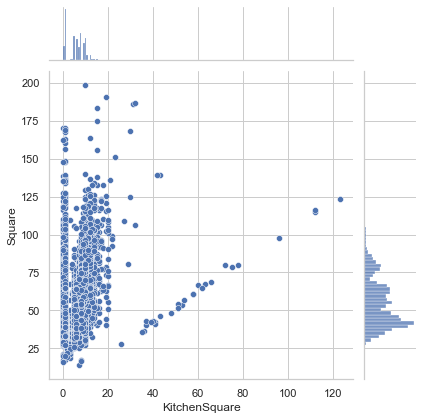

In [82]:
sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6, color='b');

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

Заполним пустые значения

In [84]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = df_train['Square'] - df_train['KitchenSquare']
df_test.loc[df_test['LifeSquare'].isna(), 'LifeSquare'] = df_test['Square'] - df_test['KitchenSquare']

In [85]:
df_train['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)
df_test['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)

# Разобъем данные на x, y

In [86]:
df_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [87]:
feature_names = ['DistrictId', 
                 'Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 'Floor', 
                 'HouseFloor', 
                 'HouseYear',
                 'Ecology_1', 
                 #'Ecology_2', 
                 #'Ecology_3', 
                 'Social_1', 
                 'Social_2', 
                 'Social_3', 
                 'Healthcare_1', 
                 'Helthcare_2',
                 'Shops_1', 
                 #'Shops_2'
                ]  
target_name = ['Price']

In [88]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train.shape, X_test.shape

X_test = df_test[feature_names]

# Построим модель Random Forest

Перекрестная проверка модели

In [89]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=6, 
                               n_estimators=150,
                               random_state=42)

In [90]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))
#R2 со всеми фичами, n_estimators=100 - 0.73671 
# без 'Ecology_2', 'Ecology_3, 'Shops_2' - 0.74034
#без 'Ecology_2', 'Ecology_3, 'Shops_2'  c n_estimators=150 - 0.74046
 
# без 'Ecology_2', 'Ecology_3, 'Shops_2', 'Helthcare_2', n_estimators=150 - 

R2: 0.74160


Важность признаков

In [91]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

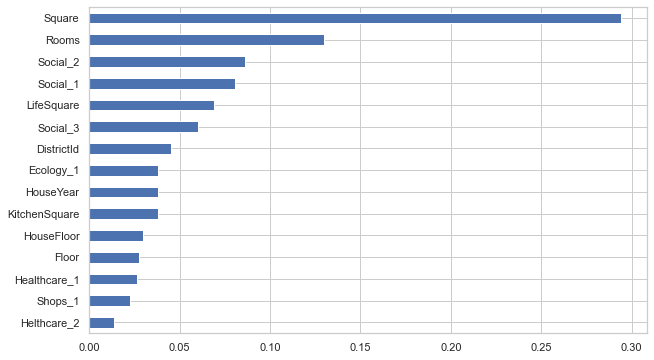

In [92]:
feat_importances.plot(kind='barh', figsize=(10, 6));

Настройка гиперпараметров модели

In [93]:
params = {
    'n_estimators': [400],
    'max_depth': [14,16,18],
    'max_features': [4,5,6]
}

In [94]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=3, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

#R2 - 0.73671 со всеми фичами 0.73671
# без 'Ecology_2', 'Ecology_3, 'Shops_2', 'Helthcare_2', 'n_estimators': [400] - 0.73699
# без 'Ecology_2', 'Ecology_3, 'Shops_2', 'Helthcare_2', 'n_estimators': [450] - 0.73682

{'max_depth': 18, 'max_features': 4, 'n_estimators': 400}
R2 на train: 0.73932


Прогнозирование на тестовом датасете

In [95]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(X_test)

In [96]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,164020.946988
1,15856,231728.622620
2,5480,233966.313660
3,15664,336737.025690
4,14275,139844.189469


In [97]:
preds.to_csv('submission_13.csv', index=False)

In [98]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB
